# Imports

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached contourpy-1.1.0-cp39-cp39-macosx_10_9_x86_64.whl (243 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.42.1-cp39-cp39-macosx_10_9_x86_64.whl (2.2 MB)
  Using cached importlib_resources-6.0.1-py3-none-any.whl (34 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_10_9_x86_64.whl (65 kB)
  Using cached matplotlib-3.7.2-cp39-cp39-macosx_10_12_x86_64.whl (7.4 MB)
  Using cached Pillow-10.0.0-cp39-cp39-macosx_10_10_x86_64.whl (3.4 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt


/Users/aryanlangeh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Code

Fetching Data

In [4]:
# Sample tickers
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'TSLA', 'NVDA', 'PYPL', 'ADBE', 'NFLX']
data = yf.download(tickers, start="2020-01-01", end="2023-08-21")['Adj Close']

[*********************100%%**********************]  10 of 10 completed


In [5]:
data

,AAPL,ADBE,AMZN,GOOG,META,MSFT,NFLX,NVDA,PYPL,TSLA
Date,,,,,,,,,,
2020-01-02,73.249023,334.429993,94.900497,68.368500,209.779999,155.093719,329.809998,59.754215,110.750000,28.684000
2020-01-03,72.536896,331.809998,93.748497,68.032997,208.669998,153.162476,325.899994,58.797798,108.760002,29.534000
2020-01-06,73.114891,333.709991,95.143997,69.710503,212.600006,153.558380,335.829987,59.044369,110.169998,30.102667
2020-01-07,72.771027,333.390015,95.343002,69.667000,213.059998,152.158264,330.750000,59.759201,109.669998,31.270666
2020-01-08,73.941628,337.869995,94.598503,70.216003,215.220001,154.581909,339.260010,59.871277,111.820000,32.809334
...,...,...,...,...,...,...,...,...,...,...
2023-08-14,179.460007,522.250000,140.570007,131.830002,306.190002,323.355408,427.779999,437.529999,63.270000,239.759995
2023-08-15,177.449997,518.700012,137.669998,130.270004,301.950012,321.179962,423.700012,439.399994,59.470001,232.960007
2023-08-16,176.570007,514.489990,135.070007,129.110001,294.290009,320.399994,415.450012,434.859985,59.680000,225.600006


Data Processing

In [6]:
returns = data.pct_change().dropna()
returns
df = pd.DataFrame(returns)
df.head()

,AAPL,ADBE,AMZN,GOOG,META,MSFT,NFLX,NVDA,PYPL,TSLA
Date,,,,,,,,,,
2020-01-03,-0.009722,-0.007834,-0.012139,-0.004907,-0.005291,-0.012452,-0.011855,-0.016006,-0.017968,0.029633
2020-01-06,0.007968,0.005726,0.014886,0.024657,0.018834,0.002585,0.030469,0.004194,0.012964,0.019255
2020-01-07,-0.004703,-0.000959,0.002092,-0.000624,0.002164,-0.009118,-0.015127,0.012107,-0.004538,0.038801
2020-01-08,0.016086,0.013438,-0.007809,0.007880,0.010138,0.015928,0.025729,0.001875,0.019604,0.049205
2020-01-09,0.021241,0.007636,0.004799,0.011044,0.014311,0.012493,-0.010611,0.010983,0.006707,-0.021945


In [7]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [8]:
num_portfolios = 10000
results = np.zeros((4, num_portfolios))
risk_free_rate = 0.047  # Adjust based on the current risk-free rate

In [9]:
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    
    # Expected portfolio return and volatility
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
    
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = sharpe_ratio
    results[3,i] = weights[np.argmax(sharpe_ratio)]

In [14]:
results_frame = pd.DataFrame(results.T, columns=['ret', 'stdev', 'sharpe', 'max_sharpe_allocation'])
results_frame.head()

,ret,stdev,sharpe,max_sharpe_allocation
0,0.001059,0.021887,-2.099014,0.140000
1,0.000907,0.022454,-2.052771,0.204017
2,0.000956,0.021179,-2.174041,0.200061
3,0.000826,0.021979,-2.100825,0.247195
4,0.001508,0.023598,-1.927768,0.022832


Visualising

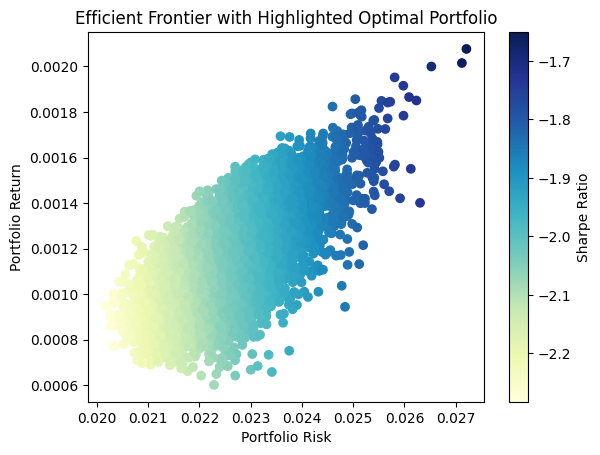

In [10]:
# Scatter plot for the random portfolios
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier with Highlighted Optimal Portfolio')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()